In [1]:
import os
import sys
import pathlib
import numpy as np

import tensorflow as tf

# if there is a GPU, enable memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
   tf.config.experimental.set_memory_growth(gpus[0], True)

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
tf.__version__

'2.1.0'

In [0]:
#!pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
#!unzip -a ./drive/My\ Drive/ipcv_dataset/test_train_val/test_train_val.zip -d ./drive/My\ Drive/ipcv_dataset/test_train_val/

In [0]:
#!rm -R ./drive/My\ Drive/ipcv_dataset/test_train_val/val

(7234, 1033, 2068)

In [0]:
#LOAD IMAGES FUNCTIONS
SIZE = (512,512)

def parse_image(img_path):
    # print("img_path - {}".format(img_path))
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "rgb", "seg")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image': image, 'segmentation_mask': mask}

@tf.function
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (SIZE[0], SIZE[1]))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE[0], SIZE[1]))

  #AUGMENTATION
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (SIZE[0], SIZE[1]))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE[0], SIZE[1]))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
#LOAD DATASET
train_img = str((train_dir / 'rgb').resolve()) + "/*.jpg"
val_img = str((val_dir / 'rgb').resolve()) + "/*.jpg"
test_img = str((test_dir / 'rgb').resolve()) + "/*.jpg"

train_dataset = tf.data.Dataset.list_files(train_img, seed=12340)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(val_img, seed=6835)
val_dataset = val_dataset.map(parse_image)

test_dataset = tf.data.Dataset.list_files(test_img, seed=1293213)
test_dataset = test_dataset.map(parse_image)


In [0]:
#PARAMETERS
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = np.ceil(train_len // BATCH_SIZE)

In [0]:
#PREPARE DATASET
dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val = dataset['val'].map(load_image_test)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

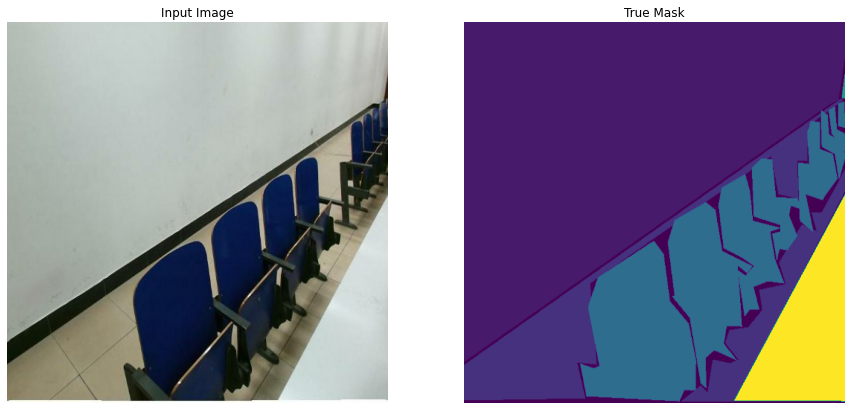

In [10]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
#MOBILENET DEPRECATED
OUTPUT_CHANNELS = 38
base_model = tf.keras.applications.MobileNetV2(input_shape=[SIZE[0], SIZE[1], 3], include_top=False, classes=OUTPUT_CHANNELS)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


In [0]:
def down_block(n_filter, kernel, act="relu", dropout_rate=0.1):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  #result.add(tf.keras.layers.Dropout(dropout_rate))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  result.add(tf.keras.layers.BatchNormalization(axis=3, scale=False))
  result.add(tf.keras.layers.MaxPooling2D((2, 2)))

  return result


def up_block(n_filter, kernel, act="relu", dropout_rate=0.2):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.UpSampling2D((2, 2)))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  #result.add(tf.keras.layers.Dropout(dropout_rate))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer, padding='same'))
  #result.add(tf.keras.layers.BatchNormalization(axis=3, scale=False))
  return result


In [0]:
def down_block_2(n_filter, kernel, act="relu", dropout_rate=0.1):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

  return result

def up_block_2(n_filter, kernel, act="relu", dropout_rate=0.2):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  #result.add(tf.keras.layers.Conv2DTranspose(n_filter, (2, 2), strides=(2, 2), padding='same'))
  result.add(tf.keras.layers.UpSampling2D((2, 2)))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))

  return result


In [0]:
#RESNET
OUTPUT_CHANNELS = 38
base_model = tf.keras.applications.ResNet50V2(input_shape=[128, 128, 3], include_top=False, classes=OUTPUT_CHANNELS)
# Use the activations of these layers
layer_names = [
    'conv1_conv', #64x64
    'conv2_block3_1_relu',   # 32x32
    'conv3_block4_1_relu',   # 16x16
    'conv4_block6_1_relu',   # 8x8
    'conv5_block3_2_relu',  # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
#base_model.summary()

In [0]:
#result = tf.keras.Sequential()
#initializer = tf.random_normal_initializer(0., 0.02)
#result.add(
#  tf.keras.layers.Conv2DTranspose(64, 3, strides=2,
#                                  padding='same',
#                                  kernel_initializer=initializer,
#                                  use_bias=False, name="myConv"))

#result.add(tf.keras.layers.BatchNormalization())

#result.add(tf.keras.layers.Softmax())

#up_stack = [
#    pix2pix.upsample(512, 3),  # 4x4 -> 8x8 
#    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#    result,
#]

up_stack = [
    up_block(512,3, act="relu"), # 4x4 -> 8x8
    up_block(256,3, act="relu"), # 8x8 -> 16x16
    up_block(128,3, act="relu"), # 16x16 -> 32x32
    up_block(64,3, act="relu"), # 32x32 -> 64x64
    up_block(32,3, act="relu"), # 64x64 -> 128x128
    up_block(16,3, act="relu"), # 128x128 -> 256x256
    up_block(8,3, act="relu"), # 256x256 -> 512x512
]



In [0]:
def unet_model(input_shape, output_channels, ds, us):
  print("UNET MODEL")
  inputs = tf.keras.layers.Input(shape=[input_shape[0], input_shape[1], 3])
  x = inputs
  #x = tf.keras.applications.resnet_v2.preprocess_input(x)
  x = down_block_2(3,3, act="relu")(x)
  first_layer = x
  x = down_block_2(3,3, act="relu")(x)

  # Downsampling through the model
  skips = ds(x)
  skips = [x] + skips#.insert(0,x)
  skips = [first_layer] + skips  #.insert(0,first_layer)
  x = skips[-1]
  skips = reversed(skips[:-1])
  
  # Upsampling and establishing the skip connections
  for up, skip in zip(us, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, 
      strides=2,
      padding='same',
      activation="softmax")

  #last_up = last_up(x)
  #last = tf.keras.layers.Conv2D(output_channels, (3, 3), activation="relu", padding='same')(last_up)
  #last_up = tf.keras.layers.UpSampling2D((2, 2))(x)
  #last = tf.keras.layers.Conv2D(output_channels, (3, 3), activation="softmax", padding='same')(last_up)
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

#metric
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

#loss
def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [15]:
model = unet_model(SIZE, OUTPUT_CHANNELS, down_stack, up_stack)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')

#metrics
miou = tf.keras.metrics.MeanIoU(OUTPUT_CHANNELS)
scc = tf.keras.metrics.SparseCategoricalAccuracy()
acc = "accuracy"

#losses
hinge_loss = tf.keras.losses.Hinge()
sparse_softmax = tf.nn.sparse_softmax_cross_entropy_with_logits
cross_entropy = tf.keras.losses.CategoricalCrossentropy()
sparse_cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model.compile(optimizer=opt,
              loss=sparse_cross_entropy,
              metrics=[acc])
#model.summary()


UNET MODEL


In [0]:
#COMPILE WITH TPU

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
miou = tf.keras.metrics.MeanIoU(OUTPUT_CHANNELS)
scc = tf.keras.metrics.SparseCategoricalAccuracy()
acc = "accuracy"
#iou = get_iou(masks, predictions)
#mean_iou_loss = tf.Variable(initial_value=-tf.log(tf.reduce_sum(iou)), name='loss', trainable=True)
#train_op = tf.train.AdamOptimizer(0.001).minimize(mean_iou_loss)
hinge_loss = tf.keras.losses.Hinge()
sparse_softmax = tf.nn.sparse_softmax_cross_entropy_with_logits
cross_entropy = tf.keras.losses.CategoricalCrossentropy()
sparse_cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()


resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model = unet_model(SIZE, OUTPUT_CHANNELS, down_stack, up_stack)
  model.compile(optimizer=opt,
              loss=sparse_cross_entropy,
              metrics=[acc])

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)#, to_file='resnet50V2_custom.png')

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

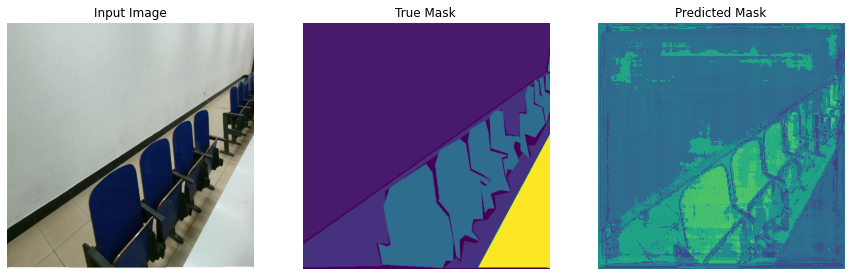

In [18]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [21]:
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_len // BATCH_SIZE // VAL_SUBSPLITS

cp_callback = tf.keras.callbacks.ModelCheckpoint(str(checkpoint_path.resolve()) + "/resnetV50_sparse_acc_block1_1.h5", 
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
 
cbck = [
  #tf.keras.callbacks.EarlyStopping(patience=2, monitor = 'val_loss'),
  #tf.keras.callbacks.TensorBoard(log_dir = log_path),
  DisplayCallback(),
  cp_callback,
]

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=15, #STEPS_PER_EPOCH,
                          validation_steps=10, #VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=cbck)
                          #callbacks=[cp_callback])
                          
# hai aumentato il learning rate
# hai diminuito il batch size
# hai tolto batch normalization dall'up_block

Epoch 1/15


KeyboardInterrupt: ignored

In [0]:
loss = model_history.history['loss']
acc = model_history.history['accuracy']
val_loss = model_history.history['val_loss']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
#LOSS
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()

#ACCURACY
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.show()

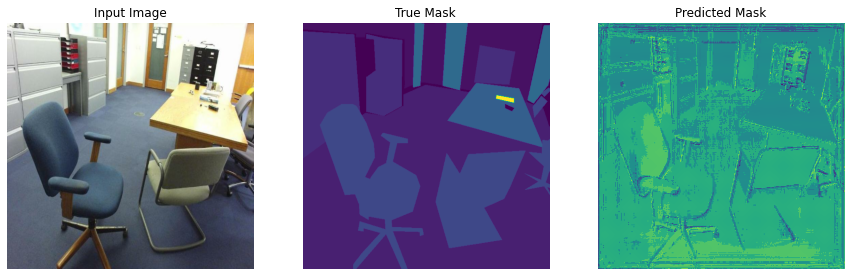

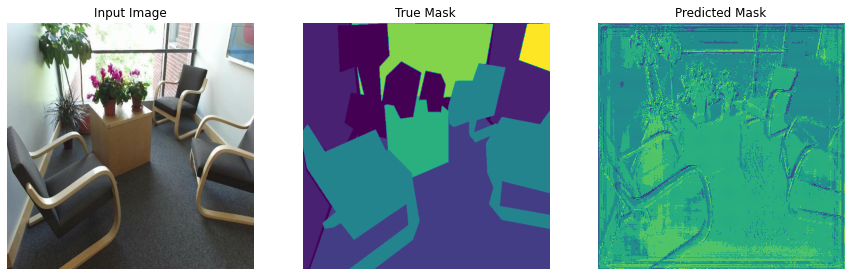

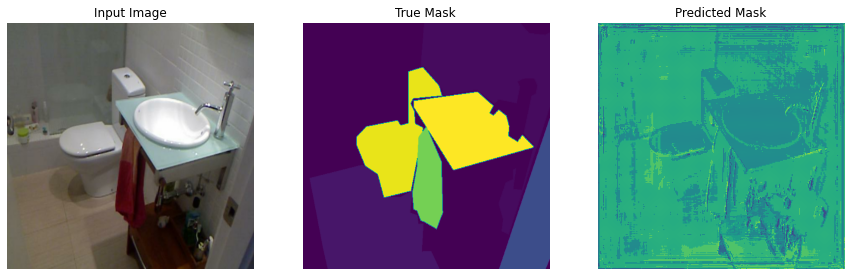

In [0]:
show_predictions(test_dataset, 3)